In this project, I am going to use Long Short Term Memory model (LSTM) for predicting air pollution. Air quality is measured by level of PM2.5 concentration which refers to atmospheric particulate matter (PM) that have a diameter of less than 2.5 micrometers.

Data set is stored on github at: https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv  

The data set has some following variables:


**No:** row number 

**year:** year of data 

**month:** month of data 

**day:** day of data 

**hour:** hour of data 

**pm2.5:** PM2.5 concentration 

**DEWP:** Dew Point 

**TEMP:** Temperature 

**PRES:** Pressure 

**cbwd:** Combined wind direction 

**Iws**: Cumulated wind speed 

**Is:** Cumulated hours of snow 

**Ir:** Cumulated hours of rain


In [23]:
## import all necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

# **1. Data exploration**

In [4]:
## read data from Github
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv

--2020-04-11 15:19:21--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2010492 (1.9M) [text/plain]
Saving to: ‘pollution.csv’

100%[======================================>] 2,010,492   --.-K/s   in 0.05s   

2020-04-11 15:19:22 (38.2 MB/s) - ‘pollution.csv’ saved [2010492/2010492]



In [5]:
### load data and show some first rows

df =pd.read_csv("pollution.csv")
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [7]:
## change columns name to have a better name capturing features

df.columns = ['No','year','month','day', 'hour', 'pollution','dew', 'temperature', 'pressure', 'wind_direction', 'wind_speed', 'snow', 'rain' ]
df.head()

,No,year,month,day,hour,pollution,dew,temperature,pressure,wind_direction,wind_speed,snow,rain
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [8]:
## compute descriptive statistics for the data

df.describe()

,No,year,month,day,hour,pollution,dew,temperature,pressure,wind_speed,snow,rain
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


We have totally 43824 observations from the year 2010 to 2014.  As can be seen, there are also some missing values. We will deal with them later in section 2. 

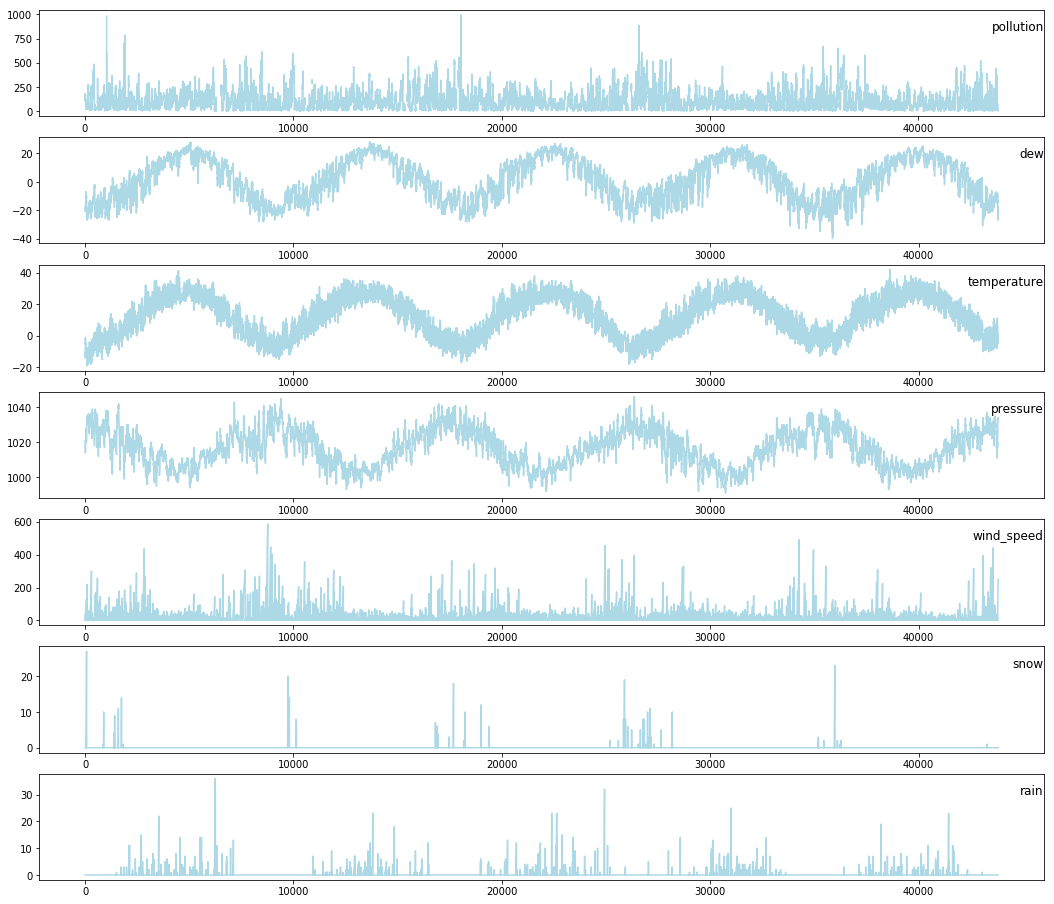

In [9]:
### Time series plot for features

names = ['pollution','dew', 'temperature', 'pressure', 'wind_speed', 'snow', 'rain']
i = 1

# plot each column
plt.figure(figsize=(18,16))

for name in names:
    plt.subplot(len(names), 1, i)
    plt.plot(df[name], color='lightblue')
    plt.title(name, y=0.75, loc='right')
    i += 1

plt.show()

From time series plots above, we see that dew and temperature are positively correlated, but dew and pressure are negatively correlated. To measure degree of correlation, we can produce matrix of correlation as follows:

In [10]:
## correlation matrix 

corr_matrix = df[['pollution','dew', 'temperature', 'pressure', 'wind_speed', 'snow', 'rain']].corr()
print(corr_matrix)

             pollution       dew  temperature  pressure  wind_speed      snow  \
pollution     1.000000  0.171423    -0.090534 -0.047282   -0.247784  0.019266   
dew           0.171423  1.000000     0.824633 -0.778346   -0.296399 -0.034410   
temperature  -0.090534  0.824633     1.000000 -0.826690   -0.154623 -0.092601   
pressure     -0.047282 -0.778346    -0.826690  1.000000    0.185355  0.069028   
wind_speed   -0.247784 -0.296399    -0.154623  0.185355    1.000000  0.021883   
snow          0.019266 -0.034410    -0.092601  0.069028    0.021883  1.000000   
rain         -0.051369  0.125090     0.049121 -0.079843   -0.010122 -0.009548   

                 rain  
pollution   -0.051369  
dew          0.125090  
temperature  0.049121  
pressure    -0.079843  
wind_speed  -0.010122  
snow        -0.009548  
rain         1.000000  


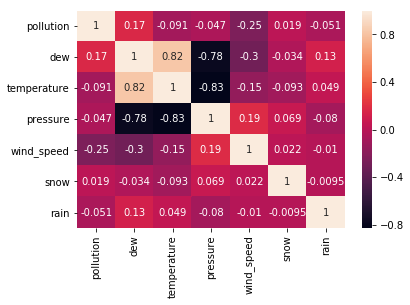

In [11]:
### heatmap displays correlation

sns.heatmap(corr_matrix, annot=True)

Time series plots above using many observations, it is  hard to see the trend of pollution, so we will compute means for pollution by year, month, day, hour and plot them, respectively.  

Text(0.5, 1.0, 'Mean Pollution by Hour')

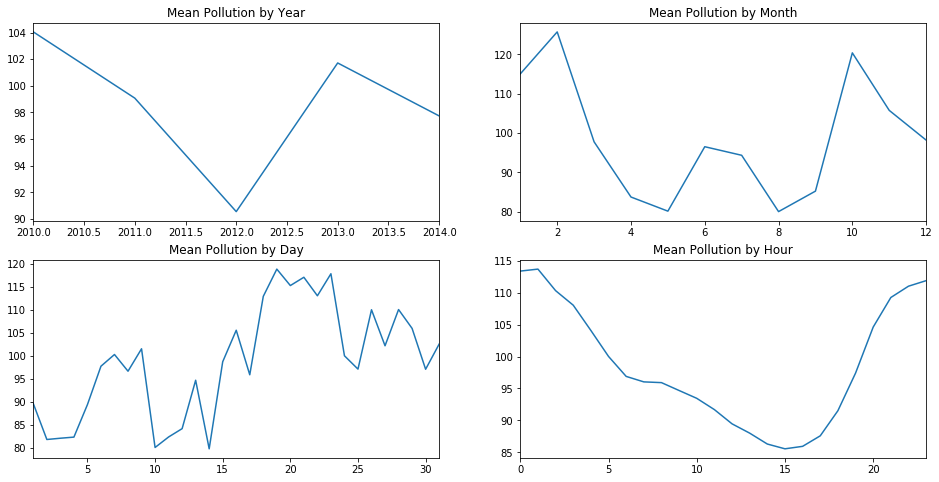

In [12]:
#visualize trend of air pollution by year, month, day and hour 

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
df.groupby('year')['pollution'].agg('mean').plot()
plt.xlabel('')
plt.title('Mean Pollution by Year')

plt.subplot(2,2,2)
df.groupby('month')['pollution'].agg('mean').plot()
plt.xlabel('')
plt.title('Mean Pollution by Month')

plt.subplot(2,2,3)
df.groupby('day')['pollution'].agg('mean').plot()
plt.xlabel('')
plt.title('Mean Pollution by Day')

plt.subplot(2,2,4)
df.groupby('hour')['pollution'].agg('mean').plot()
plt.xlabel('')
plt.title('Mean Pollution by Hour')

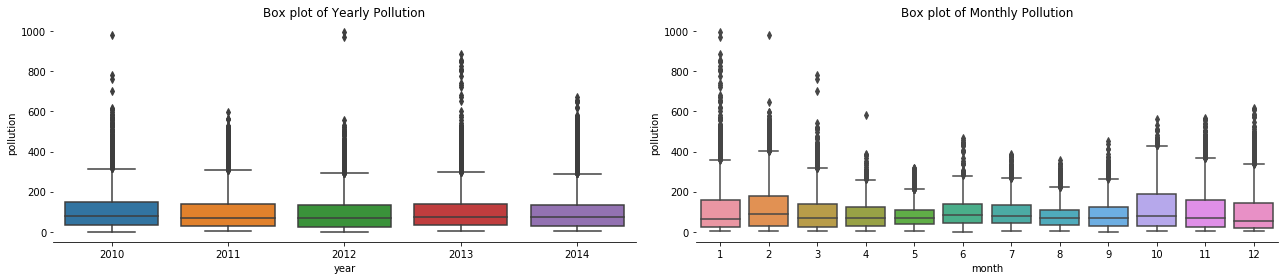

In [13]:
### Checking outliers in the data set by box plots

plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="pollution", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Pollution')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(1,2,2)
sns.boxplot(x="month", y="pollution", data=df)
plt.xlabel('month')
plt.title('Box plot of Monthly Pollution')
sns.despine(left=True)
plt.tight_layout()

As shown in box plots, the variable "pollution" contains a lot of outliers. Note that this variable also has some missing values. Therefore, we are to input them by median since it is more robust to outliers than the mean. 

# **2. Create ETL, Data Cleaning and Feature Engineering**

In [15]:
### count how many NA in the data set

pd.isnull(df).sum()

No                   0
year                 0
month                0
day                  0
hour                 0
pollution         2067
dew                  0
temperature          0
pressure             0
wind_direction       0
wind_speed           0
snow                 0
rain                 0
dtype: int64

There are totally 2067 NA for the column 'pollution'. We will input NA by median since data have many outliers as shown by boxplot above. However, in this data set, people did not measure air pollution for the first 24 hours consecutively. Therefore, we will remove the first 24 rows. The rest NA values will be replaced by median.  

In [17]:
## input missing values by median
pollution_median = df['pollution'].median()
print('median is:', pollution_median)

df = df[24:] #remove the first 24 rows

df['pollution'].fillna(pollution_median, inplace=True) #input NA by median
df.head()

median is: 72.0


,No,year,month,day,hour,pollution,dew,temperature,pressure,wind_direction,wind_speed,snow,rain
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


Next we will drop column "No" which is not used later. Also, we will create a feature called "date" by merging year, month, day and hour. After that, we also drop these variables. 

In [18]:
df2 = df.copy() ## backup data

df['date'] = pd.to_datetime(df[['year','month','day','hour']]) ## create feature date
df.index =df['date']
df.drop(['No','year','month','day','hour','date'],axis=1, inplace=True) ##remove all no needed columns
df.head()

,pollution,dew,temperature,pressure,wind_direction,wind_speed,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


To train the model LSTM,  we need to have a correct data format such that input features (dew, pressure, win direction, wind speed, snow, rain) represented in terms of time step (t-n, ..., t-2, t-1), where n is the time step. The output feature 'pollution' must have the form (t+1, t+2, ..., t+n). In this project, we will predict pollution at the time t (hour) based on weather information at the time t-1, so we get time step is 1. 


In [20]:
## create new data set with new features for LSTM model

def create_dataset(data, n_in=1, n_out=1, dropna=True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    
    cols = []
    names = []
 
    # input sequence in terms of time step (t-n, ... t-1), n is a time step
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # output sequence (t, t+1, ... t+n) for predicting
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # megre all variables together
    new_data = pd.concat(cols, axis=1)
    new_data.columns = names

    # remove rows with NA values
    if dropna:
        new_data.dropna(inplace=True)
        return new_data

In [21]:
## convert data to numpy array

values = df.values
print(values)

[[129.0 -16 -4.0 ... 1.79 0 0]
 [148.0 -15 -4.0 ... 2.68 0 0]
 [159.0 -11 -5.0 ... 3.57 0 0]
 ...
 [10.0 -22 -3.0 ... 242.7 0 0]
 [8.0 -22 -4.0 ... 246.72 0 0]
 [12.0 -21 -3.0 ... 249.85 0 0]]


In [24]:
#encode wind direction to integer numbers

encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

In [25]:
# converge all data type to float type
values = values.astype('float32')

# normalize features by min max scaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(values)

# create dataset for LTSM model from the data with normalized features
new_dataset = create_dataset(data_scaled, 1, 1)

print(new_dataset.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
1   0.000000        0.0  0.148893  0.367647  0.245902  0.527273  0.666667   
2   0.000000        0.0  0.159960  0.426471  0.229508  0.545454  0.666667   
3   0.000000        0.0  0.182093  0.485294  0.229508  0.563637  0.666667   
4   0.037037        0.0  0.138833  0.485294  0.229508  0.563637  0.666667   
5   0.074074        0.0  0.109658  0.485294  0.213115  0.563637  0.666667   

    var6(t)   var7(t)  var8(t)  
1  0.003811  0.000000      0.0  
2  0.005332  0.000000      0.0  
3  0.008391

In [26]:
# drop all columns that we do not predict

new_dataset.drop(new_dataset.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(new_dataset.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


# **3. Model Definition and Training**

We will use LSTM with 50 neurons in hidden layer and one neuron in output layer for forecasitng.
We split the data set of size 3 years for training, and two years data for testing and validation. 


In [27]:
## Define training and test data set

values = new_dataset.values

n_train_hours = 365 * 24*3


train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1] ## transpose training data
test_X, test_y = test[:, :-1], test[:, -1]  ## transpose testing data


# reshape input data to be 3D [samples, timesteps, features]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 1, 8) (26280,) (17519, 1, 8) (17519,)


The model is trained with Adam algorithm and loss function is Mean Absolute Error (MSE). 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 26280 samples, validate on 17519 samples
Epoch 1/50
 - 6s - loss: 0.0399 - val_loss: 0.0689
Epoch 2/50
 - 5s - loss: 0.0164 - val_loss: 0.0227
Epoch 3/50
 - 3s - loss: 0.0135 - val_loss: 0.0148
Epoch 4/50
 - 3s - loss: 0.0132 - val_loss: 0.0140
Epoch 5/50
 - 4s - loss: 0.0132 - val_loss: 0.0137
Epoch 6/50
 - 4s - loss: 0.0133 - val_loss: 0.0137
Epoch 7/50
 - 3s - loss: 0.0132 - val_loss: 0.0143
Epoch 8/50
 - 3s - loss: 0.0132 - val_loss: 0.0145
Epoch 9/50
 - 5s - loss: 0.0133 - val_loss: 0.0140
Epoch 10/50
 - 3s - loss: 0.0133 - val_loss: 0.0136
Epoch 11/50
 - 3s - loss: 0.0132 - val_loss: 0.0141
Epoch 12/50
 - 4s - loss: 0.0132 - val_loss: 0.0140
Epoch 13/50
 - 3s - loss: 0.0132 - val_loss: 0.0139
Epoch 14/50
 - 3s - loss: 0.0133 - val_loss: 0.0140
Epoch 15/50
 - 4s - loss: 0.0132 - val_loss: 0.0138
Epoch 16/50
 - 3s - loss: 0.0133 - val_loss: 0.0139
Epoch 1

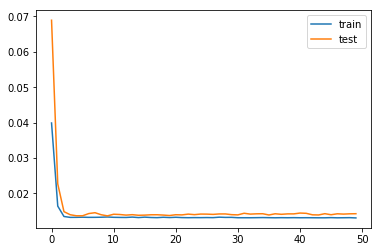

In [28]:
##training model

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#  **4. Model Evaluation**

We evaluate model by doing a prediction on test data. We then can calculate the Root Mean Squared Error (RMSE) used as an error score. Note that features of training data and testing data are all normalized before training. Hence, we need to invert into orginal scale after predicting. 

In [30]:
## prediction on test data

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.100


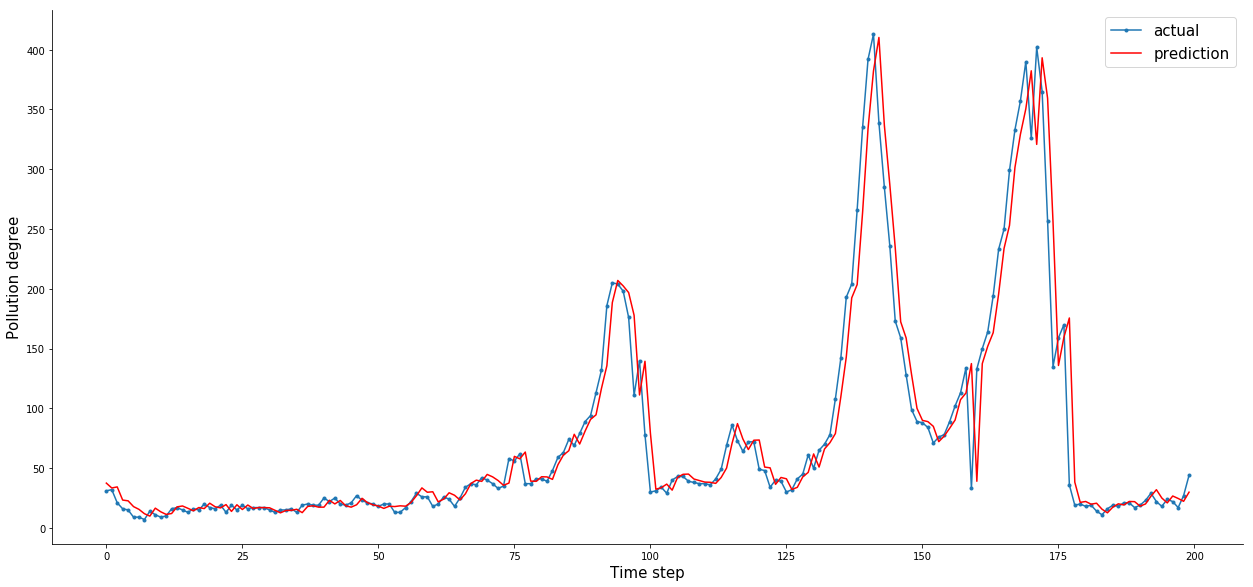

In [32]:
### We plot actual values and predicted values to see how good the performance of our model. To save space, we only visualize the first 200 values.
##The model accuracy is really amazing. 

x=[i for i in range(200)]
plt.figure(figsize=(18,8))
plt.plot(x,inv_y[:200], marker='.', label="actual")
plt.plot(x,inv_yhat[:200], 'red', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Pollution degree', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()